In [3]:
import pandas as pd
import numpy as np
# import time
# from tqdm import tqdm
import warnings
# from geopy.geocoders import Nominatim
import folium
import folium.plugins as pg
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway,zscore,randint
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
# from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

warnings.filterwarnings('ignore')

# EDA

In [4]:
loc = './../NYC property sales Dataset/nyc-rolling-sales.csv'
df = pd.read_csv(loc)

In [5]:
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,"153 AVENUE B, NEW YORK",...,5,0,5,1633,6440,1900,2,C2,6625000,19-07-2017 00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,"234 EAST 4TH STREET, NEW YORK",...,28,3,31,4616,18690,1900,2,C7,-,14-12-2016 00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,"197 EAST 3RD STREET, NEW YORK",...,16,1,17,2212,7803,1900,2,C7,-,09-12-2016 00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,"154 EAST 7TH STREET, NEW YORK",...,10,0,10,2272,6794,1913,2,C4,3936272,23-09-2016 00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,"301 EAST 10TH STREET, NEW YORK",...,6,0,6,2369,4615,1900,2,C2,8000000,17-11-2016 00:00


In [6]:
# Remove Column which are empty or not required
df.drop(columns=['Unnamed: 0','EASE-MENT'], axis=1, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       84548 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                84548 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

In [8]:
np.transpose(df.describe())

,count,mean,std,min,25%,50%,75%,max
BOROUGH,84548.0,2.998758,1.289790,1.0,2.00,3.0,4.0,5.0
BLOCK,84548.0,4237.218976,3568.263407,1.0,1322.75,3311.0,6281.0,16322.0
LOT,84548.0,376.224015,658.136814,1.0,22.00,50.0,1001.0,9106.0
ZIP CODE,84548.0,10731.991614,1290.879147,0.0,10305.00,11209.0,11357.0,11694.0
RESIDENTIAL UNITS,84548.0,2.025264,16.721037,0.0,0.00,1.0,2.0,1844.0
COMMERCIAL UNITS,84548.0,0.193559,8.713183,0.0,0.00,0.0,0.0,2261.0
TOTAL UNITS,84548.0,2.249184,18.972584,0.0,1.00,1.0,2.0,2261.0
YEAR BUILT,84548.0,1789.322976,537.344993,0.0,1920.00,1940.0,1965.0,2017.0
TAX CLASS AT TIME OF SALE,84548.0,1.657485,0.819341,1.0,1.00,2.0,2.0,4.0


In [9]:
#Check for whitespaces or - in data and replace then with np.nan
counts_ = df.apply(lambda x: str(x).count("-"))
counts_space = df.apply(lambda x: str(x).count(" "))
print(f"There are {counts_.sum().sum()} '-' and {counts_space.sum().sum()} spaces")

df.replace(to_replace={' ':np.nan,'-':np.nan}, inplace=True)

There are 27 '-' and 2037 spaces


In [10]:
def check_df(data, head=5):
    print("\n------Shape------")
    print(f'Shape     : {df.shape}\n'
          f'Size      : {df.size}\n'
          f'Dimension : {df.ndim}')
    print("\n------Types------")
    print(data.dtypes)
    print("\n------Head------")
    print(data.head(head))
    print("\n------Tail------")
    print(data.tail(head))
    print("\n------Missing Values------")
    print(data.isnull().sum())
    print("\n------Duplicated Values------")
    print(data.duplicated().sum())
    print("\n------Unique Values------")
    print(data.nunique())
    print("\n------Describe------")
    print(data.describe().T)

check_df(df)


------Shape------
Shape     : (84548, 20)
Size      : 1690960
Dimension : 2

------Types------
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

------Head------
   BOROUGH   NEIGHBORHOOD                      BUILD

In [11]:
#remove duplicates
print(f'Count of Duplicates:{df.duplicated().sum()}')
df.drop_duplicates(inplace=True)

Count of Duplicates:765


In [12]:
#Convert numerics float data to numeric format
numeric_columns = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']
for col in df.columns:
    if col in numeric_columns:
        # Convert to numeric, setting errors to 'coerce' to handle non-numeric values
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [13]:
#Convert cat type column to object
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('object')

In [14]:
# Imputing missing values in 'LAND SQUARE FEET' and 'GROSS SQUARE FEET' using the median
for col in ['LAND SQUARE FEET', 'GROSS SQUARE FEET']:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

# Removing rows where 'SALE PRICE' is missing
df = df.dropna(subset=['SALE PRICE'])

In [15]:
# Replacing borough with the names
df['BOROUGH'][df['BOROUGH'] == 1] = 'Manhattan'
df['BOROUGH'][df['BOROUGH'] == 2] = 'Bronx'
df['BOROUGH'][df['BOROUGH'] == 3] = 'Brooklyn'
df['BOROUGH'][df['BOROUGH'] == 4] = 'Queens'
df['BOROUGH'][df['BOROUGH'] == 5] = 'Staten Island'

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69607 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   BOROUGH                         69607 non-null  object 
 1   NEIGHBORHOOD                    69607 non-null  object 
 2   BUILDING CLASS CATEGORY         69607 non-null  object 
 3   TAX CLASS AT PRESENT            68934 non-null  object 
 4   BLOCK                           69607 non-null  int64  
 5   LOT                             69607 non-null  int64  
 6   BUILDING CLASS AT PRESENT       68934 non-null  object 
 7   ADDRESS                         69607 non-null  object 
 8   APARTMENT NUMBER                15441 non-null  object 
 9   ZIP CODE                        69607 non-null  int64  
 10  RESIDENTIAL UNITS               69607 non-null  int64  
 11  COMMERCIAL UNITS                69607 non-null  int64  
 12  TOTAL UNITS                     69607

In [17]:
cat_cols = df.select_dtypes(exclude='number').columns.to_list()
num_cols = [col for col in df.columns if col not in cat_cols]
cat_cols

['BOROUGH',
 'NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT PRESENT',
 'BUILDING CLASS AT PRESENT',
 'ADDRESS',
 'APARTMENT NUMBER',
 'TAX CLASS AT TIME OF SALE',
 'BUILDING CLASS AT TIME OF SALE',
 'SALE DATE']

In [18]:
for cols in cat_cols:
    print(cols)
    print(df[cols].unique())

BOROUGH
['Manhattan' 'Bronx' 'Brooklyn' 'Queens' 'Staten Island']
NEIGHBORHOOD
['ALPHABET CITY' 'CHELSEA' 'CHINATOWN' 'CIVIC CENTER' 'CLINTON'
 'EAST VILLAGE' 'FASHION' 'FINANCIAL' 'FLATIRON' 'GRAMERCY'
 'GREENWICH VILLAGE-CENTRAL' 'GREENWICH VILLAGE-WEST' 'HARLEM-CENTRAL'
 'HARLEM-EAST' 'HARLEM-UPPER' 'HARLEM-WEST' 'INWOOD' 'JAVITS CENTER'
 'KIPS BAY' 'LITTLE ITALY' 'LOWER EAST SIDE' 'MANHATTAN VALLEY'
 'MIDTOWN CBD' 'MIDTOWN EAST' 'MIDTOWN WEST' 'MORNINGSIDE HEIGHTS'
 'MURRAY HILL' 'ROOSEVELT ISLAND' 'SOHO' 'SOUTHBRIDGE' 'TRIBECA'
 'UPPER EAST SIDE (59-79)' 'UPPER EAST SIDE (79-96)'
 'UPPER EAST SIDE (96-110)' 'UPPER WEST SIDE (59-79)'
 'UPPER WEST SIDE (79-96)' 'UPPER WEST SIDE (96-116)'
 'WASHINGTON HEIGHTS LOWER' 'WASHINGTON HEIGHTS UPPER' 'BATHGATE'
 'BAYCHESTER' 'BEDFORD PARK/NORWOOD' 'BELMONT' 'BRONX PARK' 'BRONXDALE'
 'CASTLE HILL/UNIONPORT' 'CITY ISLAND' 'CITY ISLAND-PELHAM STRIP'
 'CO-OP CITY' 'COUNTRY CLUB' 'CROTONA PARK' 'EAST RIVER' 'EAST TREMONT'
 'FIELDSTON' 'FORDHAM' '

In [19]:
cat_cols.remove('ADDRESS')
cat_cols.remove('APARTMENT NUMBER')

In [20]:
df["ADDRESS SHORT"] = df['ADDRESS'].apply(lambda x: " ".join(x.split(' ')[1:]))

In [21]:
df_latlog = pd.DataFrame()
df_latlog['ADDRESS SHORT'] = df['ADDRESS SHORT'].unique()

In [22]:
# #Do a location based analysis
# from time import sleep 

# # Initialize the geolocator
# geolocator = Nominatim(user_agent="name_of_the_agent", timeout=10)

# #Get Lat and Long by using address
# def lat_long_from_zip(x):
#     # Add a random sleep interval to avoid overloading the geocoder
#     sleep(np.random.uniform(0.1, 0.2))
    
#     try:
#         location = geolocator.geocode(x, addressdetails=True)
#         if location:
#             return pd.Series({'LATITUDE': location.latitude, 'LONGITUDE': location.longitude})
#         else:
#             return pd.Series({'LATITUDE': np.nan, 'LONGITUDE': np.nan})
#     except Exception as e:
#         print(f"Error geocoding {x}: {e}")
#         return pd.Series({'LATITUDE': np.nan, 'LONGITUDE': np.nan})



# # Apply the function to each zip code and assign to new columns
# df_latlog[['LATITUDE', 'LONGITUDE']] = df_latlog['ADDRESS SHORT'].apply(lambda x: lat_long_from_zip(x))
# df_latlog.to_csv('./../NYC property sales Dataset/nyc-rolling-sales_latlong.csv')

In [23]:
df_latlog = pd.read_csv('./../NYC property sales Dataset/nyc-rolling-sales_latlong.csv').drop(columns='Unnamed: 0')
df = pd.merge(df, df_latlog, on='ADDRESS SHORT',how='left')

In [24]:
# Binning the sale prices for better visualization
# Example: Custom bins based on percentiles
custom_bins = [df['SALE PRICE'].quantile(q) for q in [0, 0.25, 0.5, 0.75, 1.0]]
df['SALE PRICE BIN'] = pd.cut(df['SALE PRICE'], bins=custom_bins, labels=[1,2,3,4])

#Heatmap
# PLot the heatmap of house prices using foliumn
center_lat = df[(df['LATITUDE'].notna())&(df['LATITUDE']<=40.9176)&(df['LATITUDE']>=40.4774)]['LATITUDE'].mean()
center_lon = df[(df['LONGITUDE'].notna())&(df['LONGITUDE']<=-73.7004)&(df['LONGITUDE']>=-74.2591)]['LONGITUDE'].mean()

MAP = folium.Map(location=[center_lat,center_lon],zoom_start=10)
df_map = df[(df['LATITUDE'].notna())&(df['LATITUDE']<=40.9176)&(df['LATITUDE']>=40.4774)&(df['LONGITUDE'].notna())&(df['LONGITUDE']<=-73.7004)&(df['LONGITUDE']>=-74.2591)&(df['SALE PRICE']<=10000000)][['LATITUDE', 'LONGITUDE', 'SALE PRICE']]


pg.HeatMap(data=df_map,radius=15).add_to(MAP)
MAP

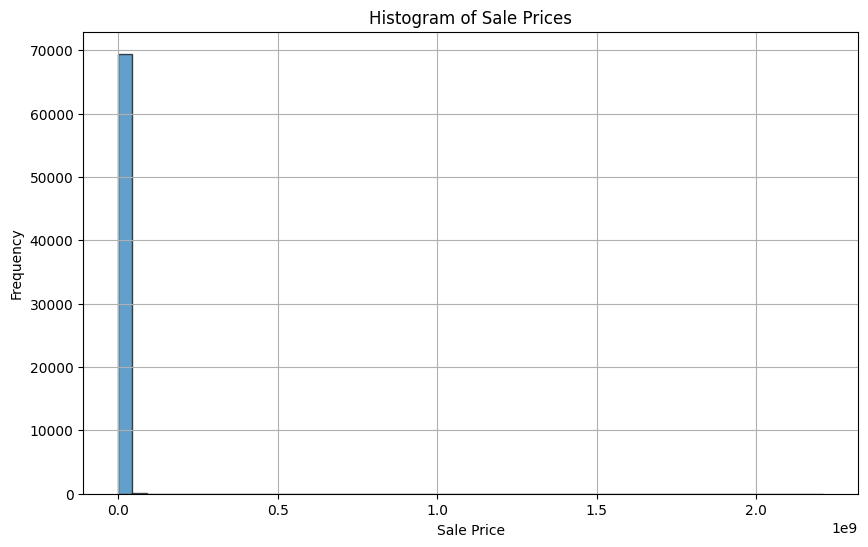

In [25]:
# Plot histogram for the Sale Prices
plt.figure(figsize=(10, 6))
plt.hist(df['SALE PRICE'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

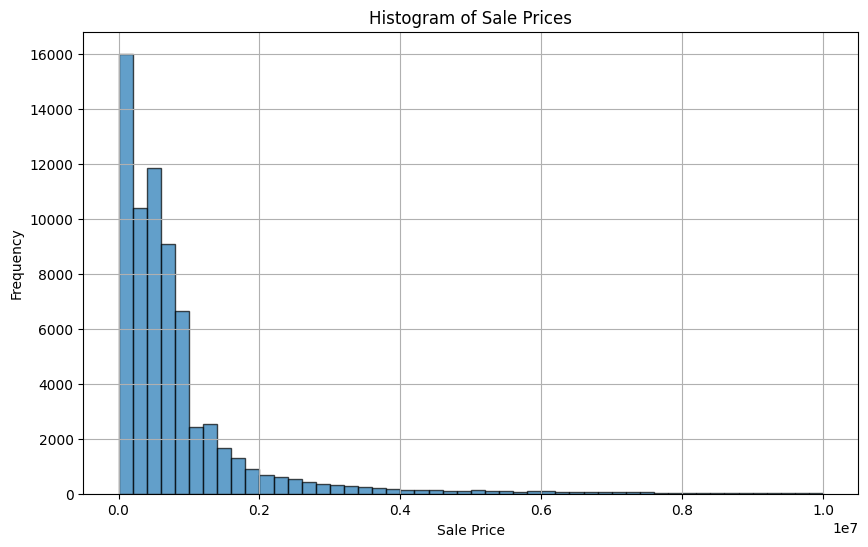

In [26]:
#Above Histplot show that the data is highly skewed toward the left.And majority of house prices are below 0.1 * 10 ^9
# Plot histogram for sale price below 100000000
plt.figure(figsize=(10, 6))
plt.hist(df[df['SALE PRICE']<=10000000]['SALE PRICE'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

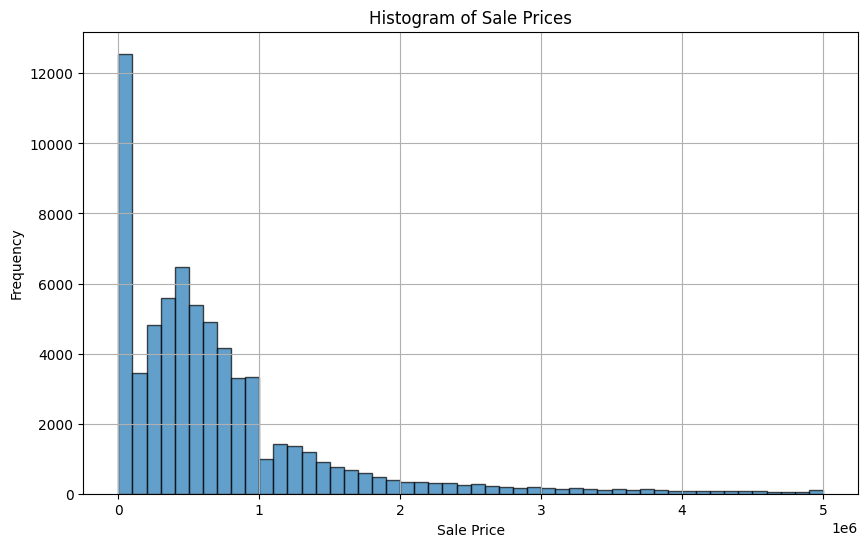

In [27]:
#Above Histplot show that the data is still skewed toward the left.And majority of house prices are below 1000000
# Plot histogram for sale price below 400000
plt.figure(figsize=(10, 6))
plt.hist(df[df['SALE PRICE']<=5000000]['SALE PRICE'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Feature Engineering

In [28]:
all_cols = cat_cols+ num_cols

In [29]:
correlation_matrix = df[num_cols].corr()
print(correlation_matrix['SALE PRICE'].sort_values(ascending=False))
threshold = 0.3
selected_features = correlation_matrix['SALE PRICE'][abs(correlation_matrix['SALE PRICE']) > threshold].index.tolist()
selected_features.remove('SALE PRICE')  
final_num_cols = selected_features
print("Selected Features:", selected_features)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.448708
TOTAL UNITS          0.126576
RESIDENTIAL UNITS    0.122465
LAND SQUARE FEET     0.059833
COMMERCIAL UNITS     0.044534
LOT                  0.012319
YEAR BUILT          -0.003708
ZIP CODE            -0.034152
BLOCK               -0.061249
Name: SALE PRICE, dtype: float64
Selected Features: ['GROSS SQUARE FEET']


In [30]:
significant_features = []

# Perform ANOVA for each categorical variable and select features
for col in cat_cols:
    categories = df[col].unique()
    anova_results = f_oneway(*[df['SALE PRICE'][df[col] == category] for category in categories])
    p_value = anova_results.pvalue
    if p_value < 0.05:  # Adjust significance level as needed
        significant_features.append(col)
        print(f'{col} is significant (p-value: {p_value:.4f})')
    else:
        print(f'{col} is not significant (p-value: {p_value:.4f})')

# Use 'significant_features' for further analysis or modeling
print("Significant features:", significant_features)
final_cat_cols = significant_features


BOROUGH is significant (p-value: 0.0000)
NEIGHBORHOOD is significant (p-value: 0.0000)
BUILDING CLASS CATEGORY is significant (p-value: 0.0000)
TAX CLASS AT PRESENT is not significant (p-value: nan)
BUILDING CLASS AT PRESENT is not significant (p-value: nan)
TAX CLASS AT TIME OF SALE is significant (p-value: 0.0000)
BUILDING CLASS AT TIME OF SALE is significant (p-value: 0.0000)
SALE DATE is not significant (p-value: 0.9902)
Significant features: ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE']


In [31]:
final_cols = final_cat_cols+final_num_cols

In [32]:
final_cols

['BOROUGH',
 'NEIGHBORHOOD',
 'BUILDING CLASS CATEGORY',
 'TAX CLASS AT TIME OF SALE',
 'BUILDING CLASS AT TIME OF SALE',
 'GROSS SQUARE FEET']

In [33]:
# Separate numerical and categorical columns
numerical_df = df[final_num_cols+['SALE PRICE']]
categorical_df = df[final_cat_cols]

# Remove outliers using Z-score method on numerical columns
z_scores = np.abs(zscore(numerical_df))
filtered_entries = (z_scores < 3).all(axis=1)  
numerical_df_filtered = numerical_df[filtered_entries]

# Concatenate filtered numerical data with categorical columns
df_final = pd.concat([numerical_df_filtered, categorical_df.loc[filtered_entries]], axis=1)


In [34]:
# Encode categorical columns
df_final = pd.get_dummies(df_final, columns=final_cat_cols, drop_first=True)


In [35]:
X = df_final
Y = df_final['SALE PRICE']
# Y_log_transformed = np.log1p(Y)

# Linear Regression Model Training and Evaluation

In [36]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [37]:
# Initialize the scaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data for X
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Fit the scaler on the training data and transform both training and testing data for Y
Y_train_scaled = scaler_Y.fit_transform(y_train.values.reshape(-1, 1))
Y_test_scaled = scaler_Y.transform(y_test.values.reshape(-1, 1))

In [38]:
# Initialize linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train_scaled, Y_train_scaled)

# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(Y_test_scaled, y_pred)
r2 = r2_score(Y_test_scaled, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.018563456738858897
R-squared (R2): 0.9817131862533589


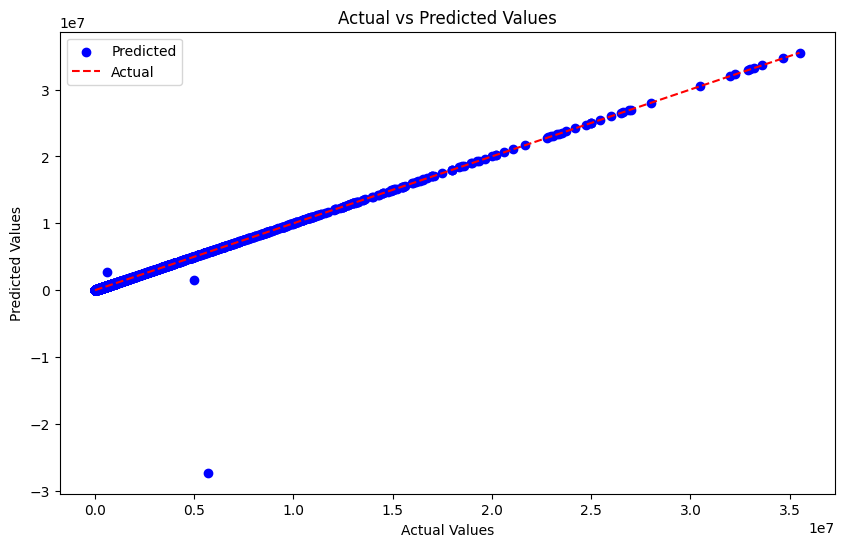

In [39]:
# Reverse the scaling of predictions to get predictions in the original scale of 'Y'
y_pred_original = scaler_Y.inverse_transform(y_pred.reshape(-1, 1))  # Inverse transform scaled predictions

# Plotting Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_original, color='blue', label='Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Actual')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

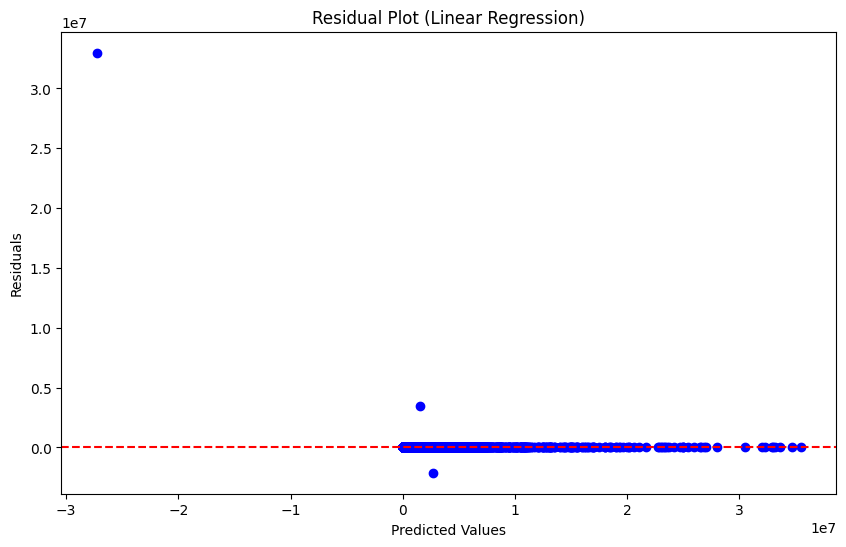

In [40]:
# Calculate residuals
residuals = y_test - y_pred_original.flatten()

# Plotting Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_original, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot (Linear Regression)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [41]:
# Predicting for Outlier data
df_outlier = df.loc[df.index.difference(df_final.index)][final_num_cols+['SALE PRICE']+final_cat_cols]
df_outlier = pd.get_dummies(df_outlier, columns=final_cat_cols, drop_first=True)

#Splitting target and features from data
X_out = df_outlier
Y_out = df_outlier['SALE PRICE']

#Add extra column from X to X_out
missing_columns = set(X.columns) - set(X_out.columns)
for col in missing_columns:
    X_out[col] = 0
X_out = X_out[X.columns]

# Fit the scaler on X and Y
# Initialize the scaler
scaler_out_X = StandardScaler()
scaler_out_Y = StandardScaler()
X_out_scaled = scaler_out_X.fit_transform(X_out)
Y_out_scaled = scaler_out_Y.fit_transform(Y_out.values.reshape(-1, 1))

y_out_pred = model.predict(X_out_scaled)

# Evaluate the model
mse = mean_squared_error(Y_out_scaled, y_out_pred)
r2 = r2_score(Y_out_scaled, y_out_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

Mean Squared Error (MSE): 0.34738199183310914
R-squared (R2): 0.652618008166891


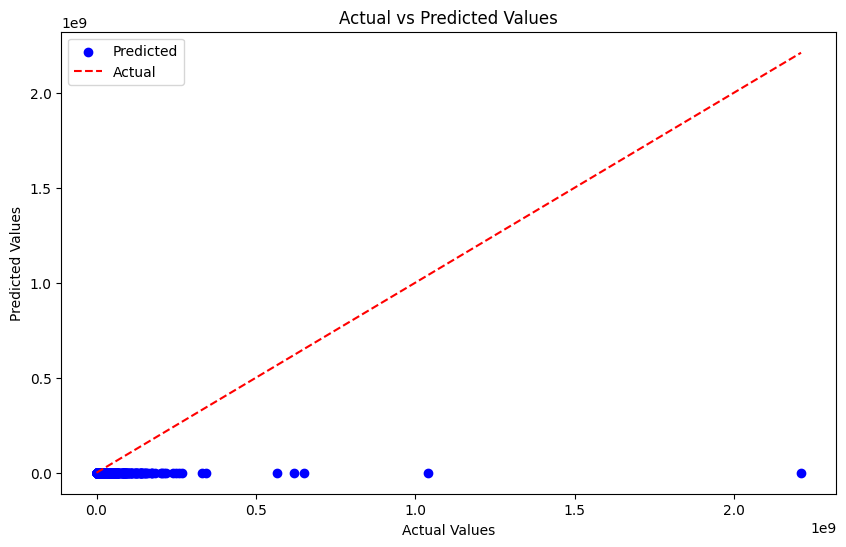

In [42]:
# Reverse the scaling of predictions to get predictions in the original scale of 'Y'
y_pred_original = scaler_Y.inverse_transform(y_out_pred.reshape(-1, 1))  # Inverse transform scaled predictions

# Plotting Actual vs Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(Y_out, y_out_pred, color='blue', label='Predicted')
plt.plot([min(Y_out), max(Y_out)], [min(Y_out), max(Y_out)], linestyle='--', color='red', label='Actual')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

# Applying Other Regression Models

##### Working with data without removing outlier as the extreme house prices is possible for models such as Random Forest which are less sensitive to outlier since they split data based on feature values

##### Not using SVR as it is sensitive to outliers since it tries to fit a hyperplane that minimizes error across all data points

In [43]:
num_cols.remove('SALE PRICE')
cat_cols.remove('SALE DATE')
X = df[num_cols+cat_cols]
Y = df['SALE PRICE']

In [44]:
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True).astype(int)

In [45]:
X_encoded.shape

(69607, 643)

In [46]:
def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True

    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.values, ix) for ix in variables]

        max_vif = max(vif)
        if max_vif > thresh:
            max_vif_index = vif.index(max_vif)
            del variables[max_vif_index]
            dropped = True

    print('Remaining variables:', X.columns[variables])
    return X.iloc[:, variables]

# Calculate VIF and reduce multicollinearity
X_reduced = calculate_vif(X_encoded)


KeyboardInterrupt: 

In [45]:
# # Calculate VIF for the dataset
# def calculate_vif(X):
#     vif_data = pd.DataFrame()
#     vif_data["feature"] = X.columns
#     vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     return vif_data

# # Calculate VIF
# vif_df = calculate_vif(X)
# print(vif_df)
# Example: Removing features with VIF > 10
# high_vif_features = vif_df[vif_df["VIF"] > 10]["feature"]
# X_encoded_df = X_encoded.drop(columns=high_vif_features, errors='ignore')

In [46]:
# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

In [47]:
#Apply Robust Scaler to handle oultier
rbscaler = RobustScaler()
X_train_scaled = rbscaler.fit_transform(X_train)
X_test_scaled = rbscaler.transform(X_test)

In [48]:

# Hyperparameter tuning for Decision Tree Regressor

#create a custom function for Adj R2
def adjusted_r2_score(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    p = X.shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return adj_r2
adjusted_r2_scorer = make_scorer(adjusted_r2_score, X=X, greater_is_better=True)



In [49]:

# #Specify Hyperparameters to tune

# dt_param_distributions = {
#     'criterion' :[ 'absolute_error'], #using absolute error as data has outliers
#     'max_depth': [3,5,7,10,20,30,None],
#    'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 5, 10]
# }
# dt_model = DecisionTreeRegressor()
# dt_grid_search = GridSearchCV(dt_model, param_grid=dt_param_distributions, 
#                                  cv=5, verbose=4, scoring=adjusted_r2_scorer)
# dt_grid_search.fit(X_train_scaled, y_train)

# # Best Decision Tree model
# best_dt_model = dt_grid_search.best_estimator_



In [ ]:
# Hyperparameter tuning for Random Forest Regressor
rf_param_distributions = {
    'n_estimators': [100,200,300,400],
   'criterion' :[ 'absolute_error'], #using absolute error as data has outliers
    'max_depth': [3,5,7,10,None],
   'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

rf_model = RandomForestRegressor()
rf_random_search = RandomizedSearchCV(rf_model, param_grid=rf_param_distributions, 
                                 cv=5, verbose=4, scoring='r2',n_iter=50,random_state=42)
rf_random_search.fit(X_train_scaled, y_train)

# Best Random Forest model
best_rf_model = rf_random_search.best_estimator_



In [ ]:
# Make predictions
# dt_predictions = best_dt_model.predict(X_test_scaled)
rf_predictions = best_rf_model.predict(X_test_scaled)

# Evaluate the models
from sklearn.metrics import mean_absolute_error, mean_squared_error

# dt_mae = mean_absolute_error(y_test, dt_predictions)
# dt_mse = mean_squared_error(y_test, dt_predictions)
# dt_r2 = r2_score(y_test,  dt_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

# print(f"Decision Tree MAE: {dt_mae}, MSE: {dt_mse}, R2: {dt_r2}")
print(f"Random Forest MAE: {rf_mae}, MSE: {rf_mse}, R2: {rf_r2}")